In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.datasets import load_boston
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression, SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from minepy import MINE

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

boston = load_boston()

bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target

X = bos.drop('PRICE', axis = 1)
Y = bos['PRICE']


In [2]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
print(bos.describe())

# AGE, PRICE seem to have maximm values capped
# CHAS is a 0 or 1 flag

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.593761   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.596783   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.647423   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

In [4]:
# Looking for nulls
print(X.isnull().any())

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
dtype: bool


C:\Users\jimsu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


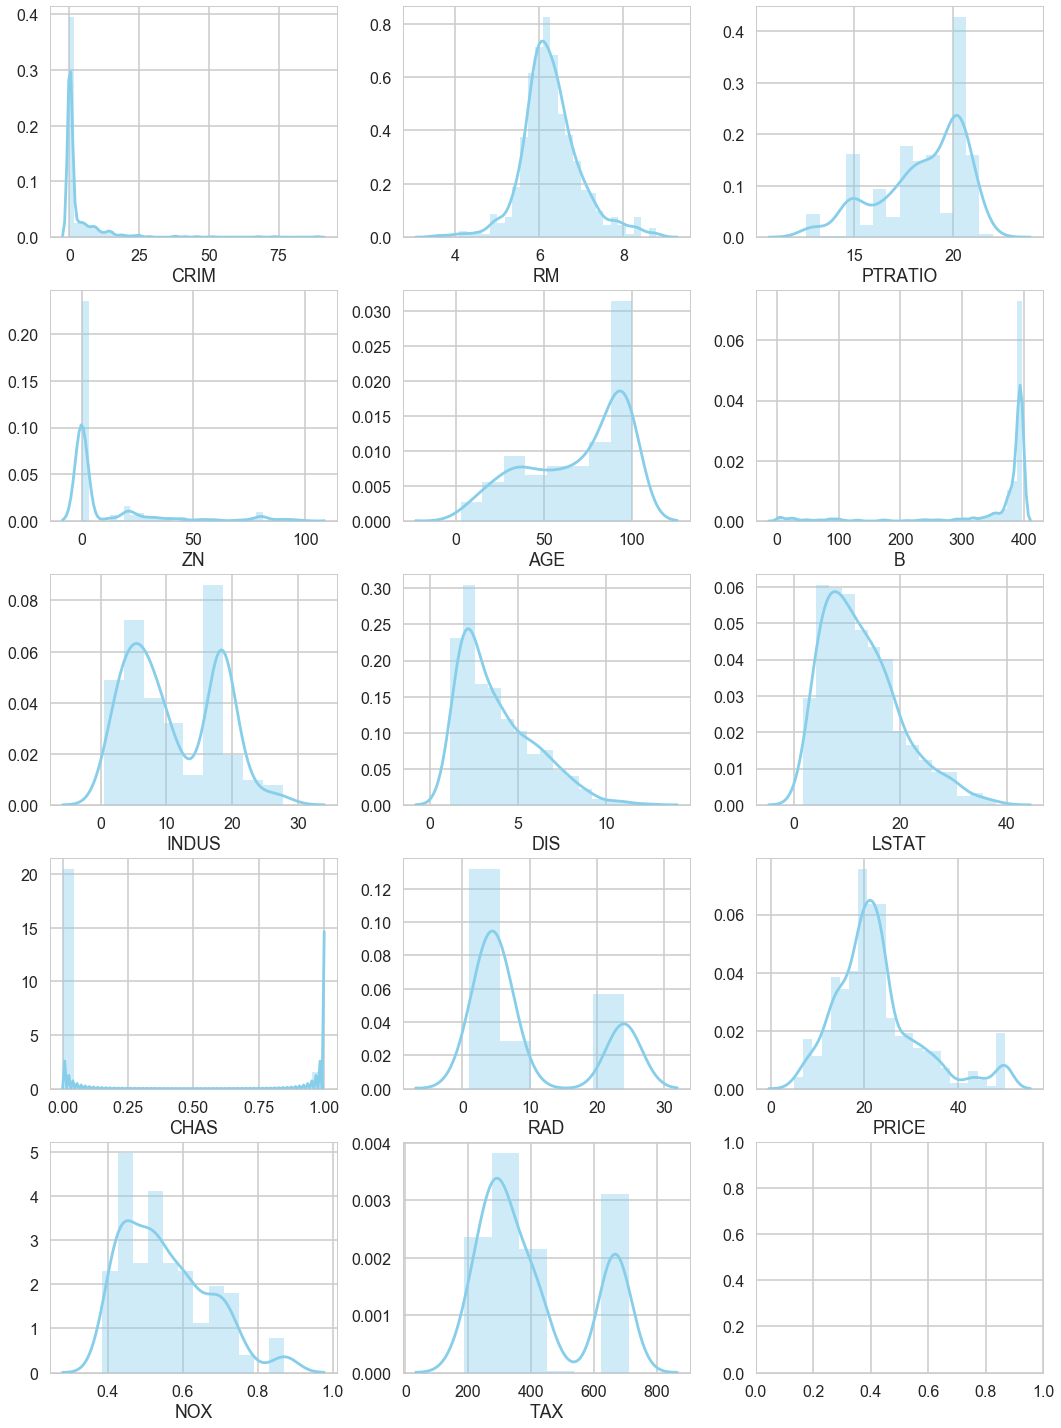

In [5]:
   
# Plot Histograms for each variable
x_plot = 5
y_plot = 3

f, axes = plt.subplots(x_plot, y_plot, figsize=(15, 20)) 
plt.tight_layout()

x_axis = -1
y_axis = 0
for col in bos.columns:
    x_axis += 1

    sns.distplot( bos[col], color="skyblue", ax=axes[x_axis , y_axis])
    
    if x_axis == x_plot-1:
        x_axis = -1
        y_axis += 1


# Default PRICE at 50, consider removing as outliers
# AGE defaults to 100 if higher, but leave as is
# B many of the values are similar, just means not a lot of variation by town
# CRIM crime rates are fairly uniform and low in most towns
# ZN usually zero so those are residential zoned areas


C:\Users\jimsu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


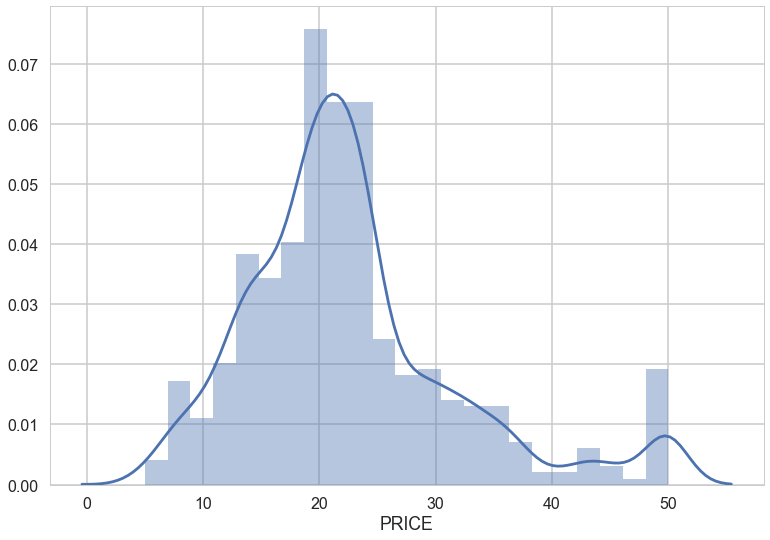

In [6]:
# Histogram
sns.distplot( bos["PRICE"] )

# Values at 50 seem to be default or missing values

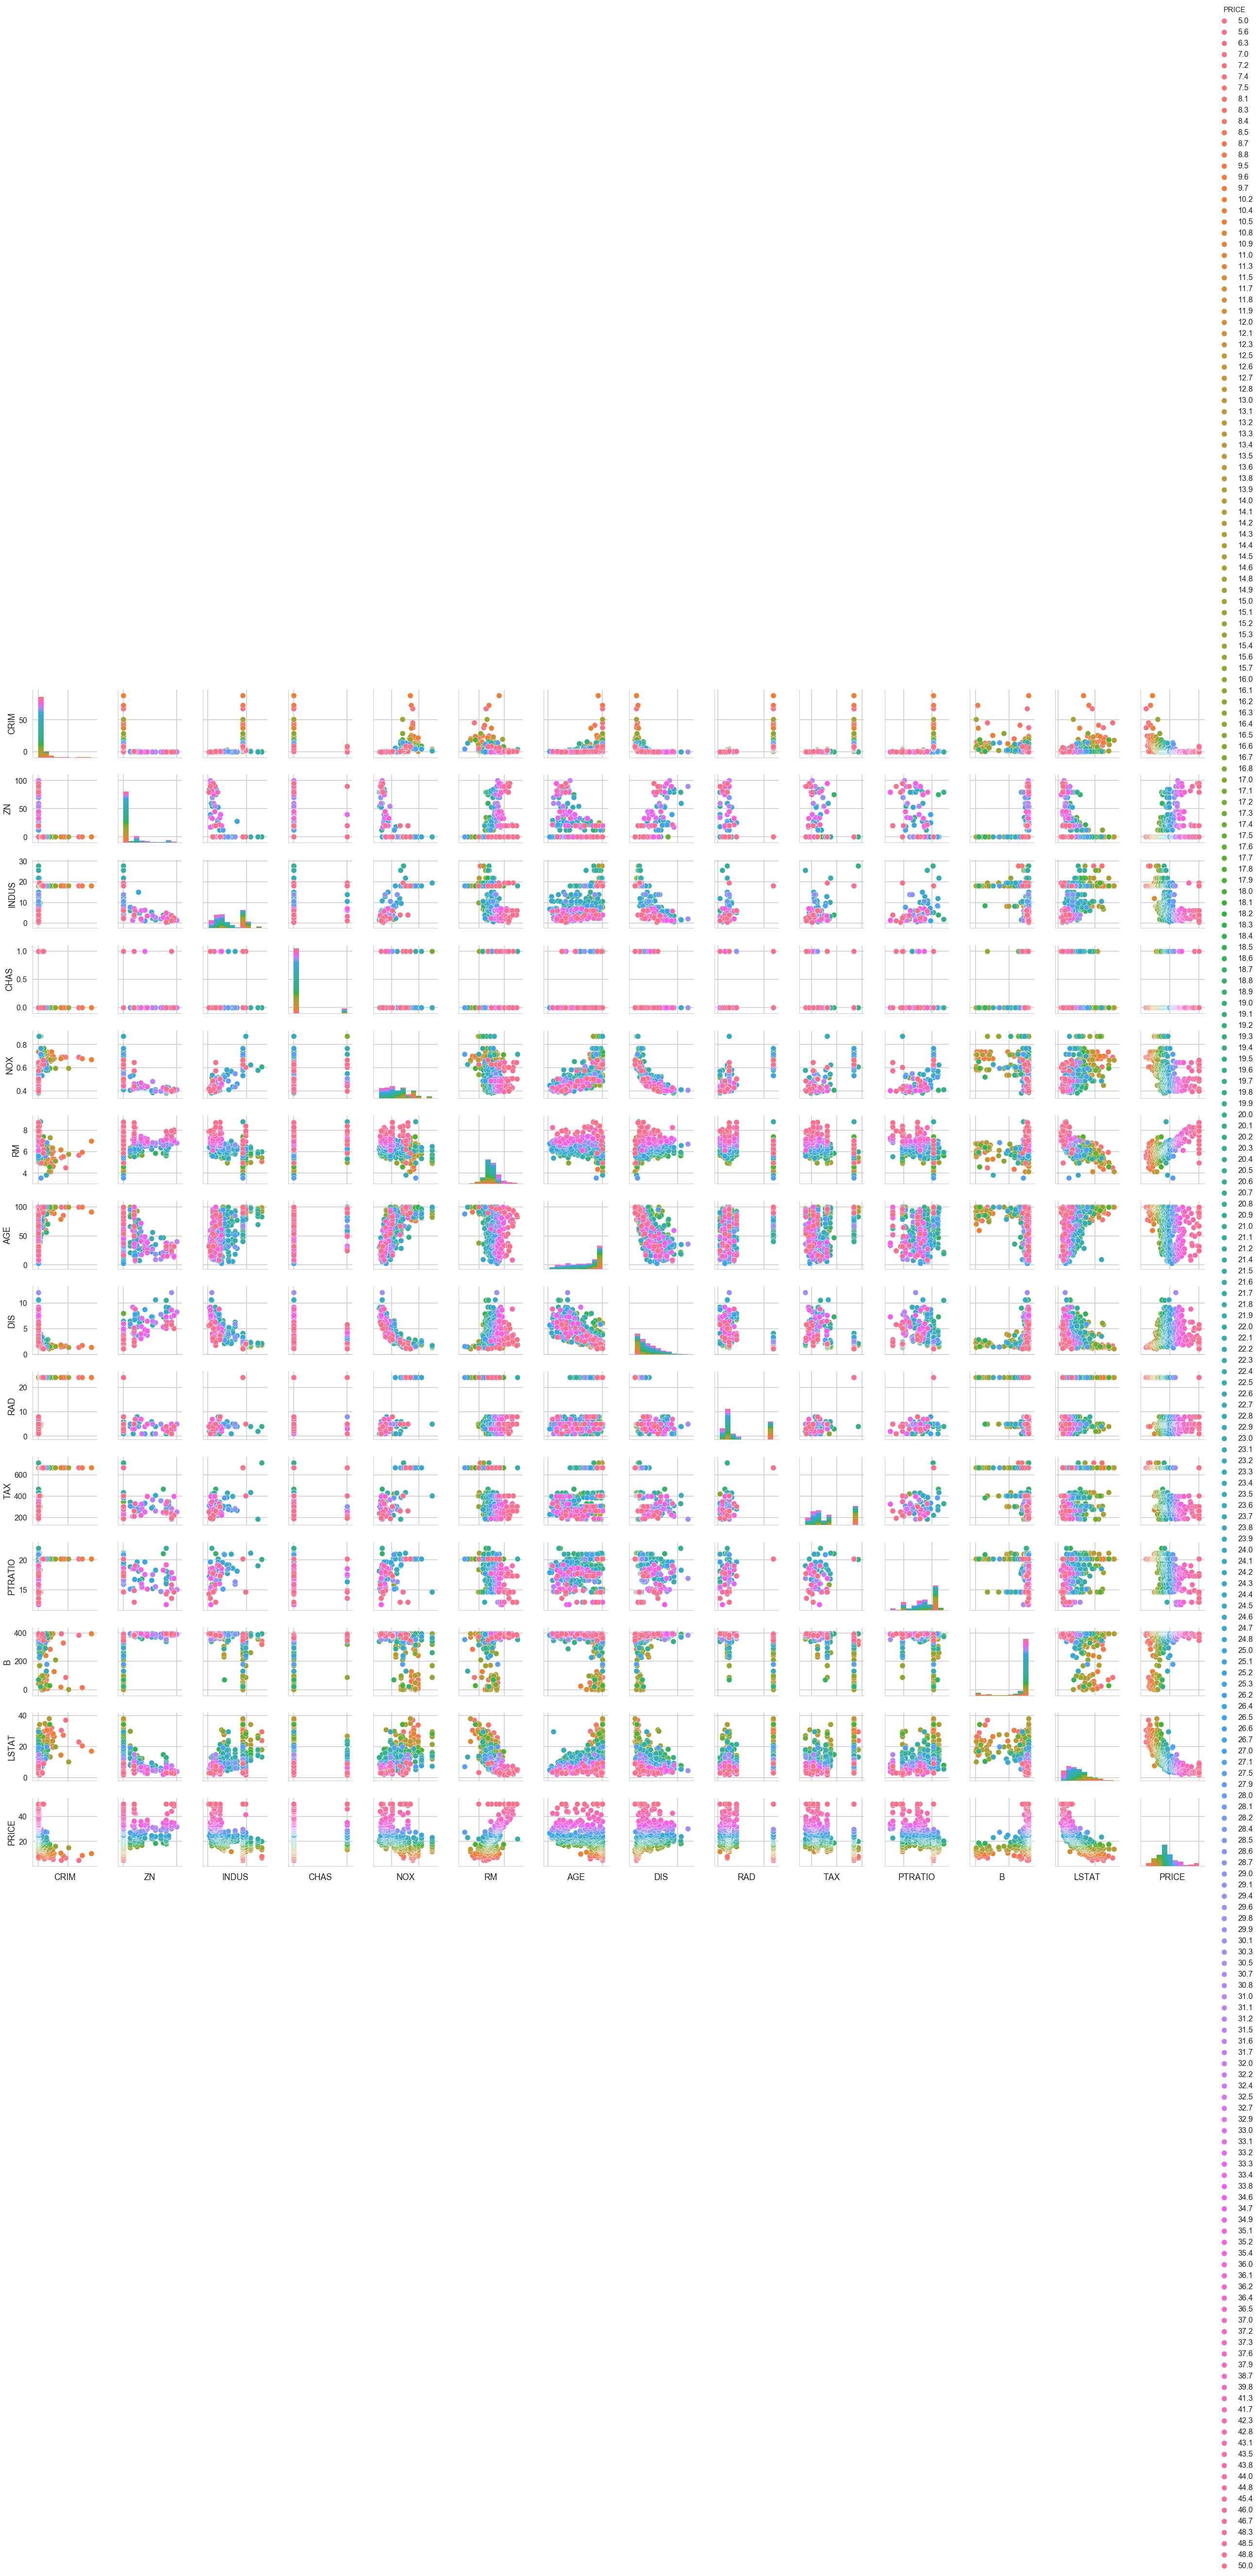

In [7]:
# Paris Plot
g = sns.pairplot(bos, hue='PRICE')
g.set(xticklabels=[]);

# relationship between the following
# INDUS and DIS, PTRATIO
# NOX and RM, AGE, DIS, PTRATIO, LSTAT,PRICE 
# RM and LSTAT, PRICE
# AGE and NOX, DIS, PTRATIO
# DIS and NOX, AGE, PTRATIO
# LSTAT and RM, DIS, PRICE
# PRICE and RM, LSTAT

# implies using LSTAT, RM, PTRATIO, NOX
# implies not all feature have a linear relationship with price, so may need to use non-linear model


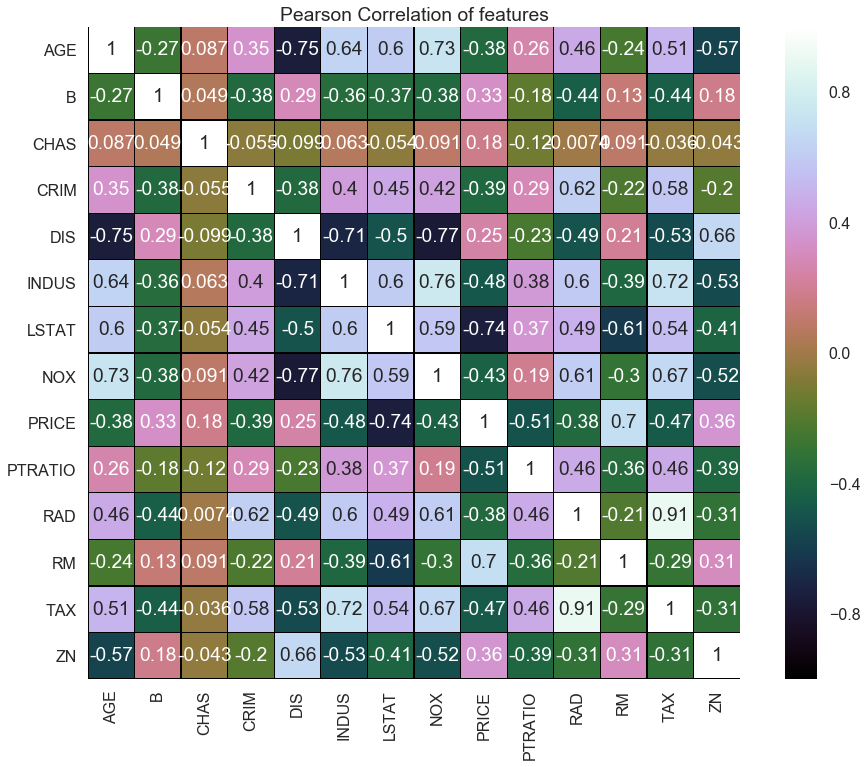

In [8]:
# Pearson Correlation
str_list = [] # empty list to contain columns with strings (words)

for colname, colvalue in bos.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)

# Get to the numeric columns by inversion            
num_list = bos.columns.difference(str_list) 
# Create Dataframe containing only numerical features
bos_num = bos[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
sns.heatmap(bos_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

# Highly correlated 
# AGE and DIS, INDUS, NOX, ZN
# CRIM and RAD
# DIS and AGE, INDUS, NOX, ZN
# INDUS and LSTAT, PRICE, TAX
# LSTAT and AGE, DIS, INDUS, NOX, PRICE, RAD, RM, TAX
# NOX and AGE, DIS, INDUS, LSTAT, RAD, TAX, ZN
# PRICE and LSTAT, RM
# PTRATIO and 
# RAD and CRIM, INDUS, NOX, TAX
# RM and LSTAT, PRICE
# TAX and AGE, CRIM, DIS, INDUS, LSTAT, NOX, RAD
# ZN and AGE, DIS, INDUS, NOX

# Should include items highly correlated to PRICE: LSTAT, RM
# If I include these two items, then we can exclude items that are highly corrected to LSTAT and RM
# Exclude: AGE, DIS, INDUS, NOX, RAD, TAX
# Suggests including PTRATIO that doesn't correlate to anything

In [ ]:
# Final Conclusion for Data Exploration

# Remove default PRICE at 50
# must use LSTAT, RM, PTRATIO